# 2. logistic_regression（逻辑回归）

# 备注
运行环境：python 3.6  
现在我知道我应该考虑列向量，而Tensorflow对数据的形状非常挑剔。 但是在numpy中，正常的一维ndarray已经被表示为列向量。 如果我重新塑造$\mathbb{R}^n$ 为 $\mathbb{R}^{n\times1}$，它不再是列向量了，而是是1列的矩阵,那使用scipy会有麻烦。
*所以我们应该把TensorFlow的数据视为特殊情况。 我们继续使用numpy的惯例。

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
# import tensorflow as tf
from sklearn.metrics import classification_report#这个包是评价报告

# 准备数据

In [149]:
data = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'admitted'])
data.head()#看前五行

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [150]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


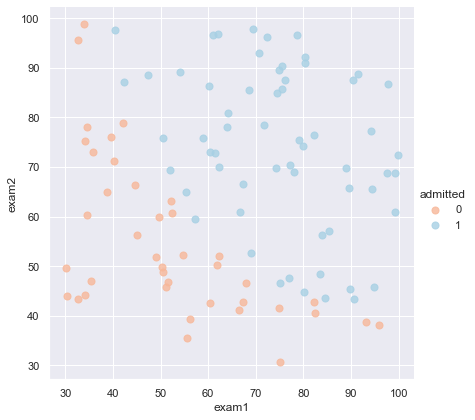

In [151]:
sns.set(context="notebook", style="darkgrid", palette=sns.color_palette("RdBu", 2))
# hue是色调，用admitted区分两种数据
sns.lmplot('exam1', 'exam2', hue='admitted', data=data,
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )
plt.show()#看下数据的样子

In [152]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并
    return data.iloc[:, :-1]  # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放

In [153]:
X = get_X(data)
print(X.shape)
print(X.head())
y = get_y(data)
print(y.shape)

(100, 3)
   ones      exam1      exam2
0   1.0  34.623660  78.024693
1   1.0  30.286711  43.894998
2   1.0  35.847409  72.902198
3   1.0  60.182599  86.308552
4   1.0  79.032736  75.344376
(100,)


# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 


In [154]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

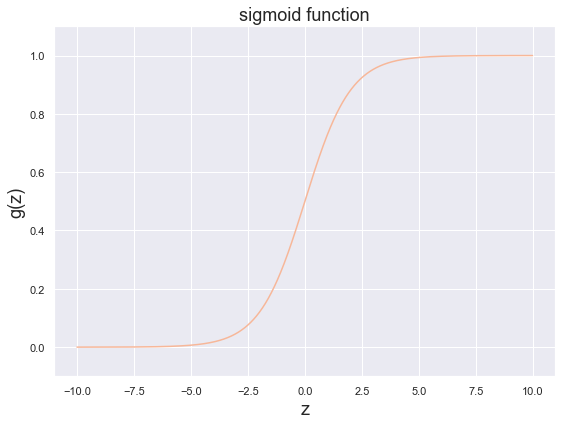

In [155]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(-10, 10, step=0.01),
        sigmoid(np.arange(-10, 10, step=0.01)))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('g(z)', fontsize=18)
ax.set_title('sigmoid function', fontsize=18)
plt.show()

# cost function(代价函数)
> * $max(\ell(\theta)) = min(-\ell(\theta))$  
> * choose $-\ell(\theta)$ as the cost function

$$ \begin{align}& J(\theta)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ & =\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ \end{align} $$


In [156]:
theta =np.zeros(3) # X(m*n) so theta is n*1
# theta = np.array([0.1,0.2,0.3])

In [157]:
# 代价函数
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))

# X @ theta与X.dot(theta)等价

In [158]:
cost(theta, X, y)

0.6931471805599453

# gradient descent(梯度下降)
* 这是批量梯度下降（batch gradient descent）  
* 转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [159]:
def gradient(theta, X, y):
#     '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

In [160]:
gradient(theta, X, y)

ones     -0.100000
exam1   -12.009217
exam2   -11.262842
dtype: float64

# 拟合参数
> * 这里我使用 [`scipy.optimize.minimize`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) 去寻找参数  


In [161]:
import scipy.optimize as opt

In [162]:
# 求解代价函数最小值
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=gradient)

In [163]:
print(res)

     fun: 0.20349770249211604
     jac: array([2.67323741e-05, 1.76854178e-03, 1.64489142e-03])
 message: 'Optimization terminated successfully.'
    nfev: 73
    nhev: 0
     nit: 29
    njev: 204
  status: 0
 success: True
       x: array([-25.16376776,   0.20625197,   0.20149048])


# 用训练集预测和验证

In [164]:
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

In [165]:
final_theta = res.x
# print(final_theta)
# print(X.size)
y_pred = predict(X, final_theta)


print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



# 寻找决策边界
http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier
> $X \times \theta = 0$  (this is the line)

In [166]:
print(res.x) # this is final theta

[-25.16376776   0.20625197   0.20149048]


In [167]:
coef = -(res.x / res.x[2])  # find the equation
print(coef)

x = np.arange(130, step=0.1)
y = coef[0] + coef[1]*x

[124.88812168  -1.02363132  -1.        ]


In [168]:
data.describe()  # find the range of x and y

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


> you know the intercept would be around 125 for both x and y

d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


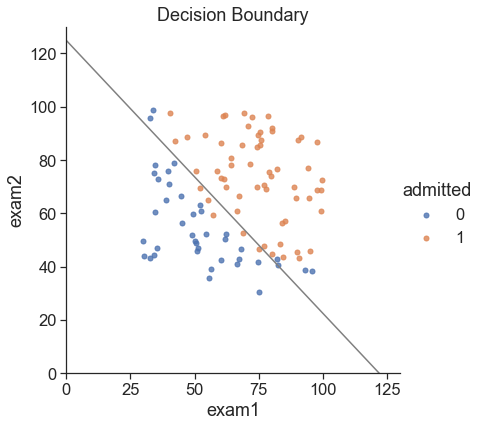

In [169]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x, y, 'grey')
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()

# 3- 正则化逻辑回归

In [170]:
df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


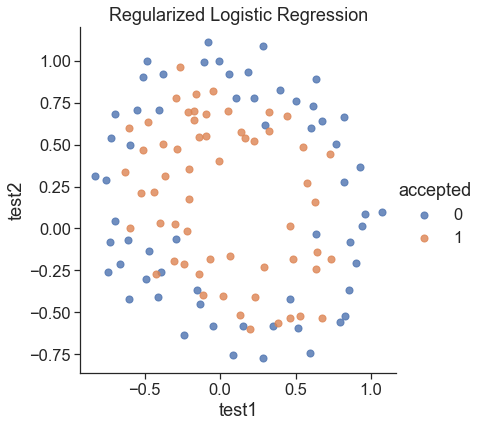

In [171]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('test1', 'test2', hue='accepted', data=df, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )

plt.title('Regularized Logistic Regression')
plt.show()

# feature mapping（特征映射）

polynomial expansion

```
for i in 0..i
  for p in 0..i:
    output x^(i-p) * y^p
```
<img style="float: left;" src="../img/mapped_feature.png">

In [172]:
def feature_mapping(x, y, power, as_ndarray=False):
#     """return mapped features as ndarray or dataframe"""
    # data = {}
    # # inclusive
    # for i in np.arange(power + 1):
    #     for p in np.arange(i + 1):
    #         data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)

    data = {"f{}{}".format(i - p, p): np.power(x, i - p) * np.power(y, p)
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).as_matrix()
    else:
        return pd.DataFrame(data)


In [173]:
x1 = np.array(df.test1)
x2 = np.array(df.test2)

In [174]:
data = feature_mapping(x1, x2, power=6)
print(data.shape)
data.head()

(118, 28)


,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [175]:
data.describe()

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
count,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,118.000000,...,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02
mean,1.0,0.054779,0.183102,0.247575,-0.025472,0.301370,5.983333e-02,0.030682,0.015483,0.142350,...,0.018278,4.089084e-03,0.115710,7.837118e-02,-0.000703,1.893340e-02,-0.001705,2.259170e-02,-0.006302,1.257256e-01
std,0.0,0.496654,0.519743,0.248532,0.224075,0.284536,2.746459e-01,0.134706,0.150143,0.326134,...,0.058513,9.993907e-02,0.299092,1.938621e-01,0.058271,3.430092e-02,0.037443,4.346935e-02,0.090621,2.964416e-01
min,1.0,-0.830070,-0.769740,0.000040,-0.484096,0.000026,-5.719317e-01,-0.358121,-0.483743,-0.456071,...,-0.142660,-4.830370e-01,-0.270222,6.472253e-14,-0.203971,2.577297e-10,-0.113448,2.418097e-10,-0.482684,1.795116e-14
25%,1.0,-0.372120,-0.254385,0.043243,-0.178209,0.061086,-5.155632e-02,-0.023672,-0.042980,-0.016492,...,-0.001400,-7.449462e-03,-0.001072,8.086369e-05,-0.006381,1.258285e-04,-0.005749,3.528590e-04,-0.016662,2.298277e-04
50%,1.0,-0.006336,0.213455,0.165397,-0.016521,0.252195,-2.544062e-07,0.006603,-0.000039,0.009734,...,0.001026,-8.972096e-09,0.000444,4.527344e-03,-0.000004,3.387050e-03,-0.000005,3.921378e-03,-0.000020,1.604015e-02
75%,1.0,0.478970,0.646563,0.389925,0.100795,0.464189,1.099616e-01,0.086392,0.079510,0.270310,...,0.021148,2.751341e-02,0.113020,5.932959e-02,0.002104,2.090875e-02,0.001024,2.103622e-02,0.001289,1.001215e-01
max,1.0,1.070900,1.108900,1.146827,0.568307,1.229659,1.228137e+00,0.449251,0.505577,1.363569,...,0.287323,4.012965e-01,1.676725,1.508320e+00,0.250577,2.018260e-01,0.183548,2.556084e-01,0.436209,1.859321e+00


# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [176]:
theta = np.zeros(data.shape[1])
X = feature_mapping(x1, x2, power=6)
print(X.shape)

y = get_y(df)
print(y.shape)

(118, 28)
(118,)


In [177]:
def regularized_cost(theta, X, y, l=1):
#     '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term
#正则化代价函数

In [178]:
regularized_cost(theta, X, y, l=1)

0.6931471805599454

this is the same as the not regularized cost because we init theta as zeros...
因为我们设置theta为0，所以这个正则化代价函数与代价函数的值相同

# regularized gradient(正则化梯度)
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} \right)+\frac{\lambda }{m}{{\theta }_{j}}\text{ }\text{             for  j}\ge \text{1}$$

In [179]:
def regularized_gradient(theta, X, y, l=1):
#     '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

In [180]:
regularized_gradient(theta, X, y)

f00    0.008475
f10    0.018788
f01    0.000078
f20    0.050345
f11    0.011501
f02    0.037665
f30    0.018356
f21    0.007324
f12    0.008192
f03    0.023476
f40    0.039349
f31    0.002239
f22    0.012860
f13    0.003096
f04    0.039303
f50    0.019971
f41    0.004330
f32    0.003386
f23    0.005838
f14    0.004476
f05    0.031008
f60    0.031031
f51    0.001097
f42    0.006316
f33    0.000409
f24    0.007265
f15    0.001376
f06    0.038794
dtype: float64

# 拟合参数

In [181]:
import scipy.optimize as opt

In [182]:
print('init cost = {}'.format(regularized_cost(theta, X, y)))

res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)
res

init cost = 0.6931471805599454


     fun: 0.5290027297127309
     jac: array([-1.02331192e-07,  1.16573581e-08, -1.13146499e-08, -5.93330905e-08,
        1.53518404e-08, -6.11006109e-10,  3.69153733e-08, -3.78360557e-08,
        5.91349666e-10,  1.37418341e-08, -8.99546470e-08, -1.57424741e-08,
       -6.48324154e-08,  5.57567212e-10, -1.90760313e-08,  1.60874750e-08,
       -2.11863353e-08, -2.18643583e-08, -2.08393162e-08,  1.19810268e-09,
        1.12326493e-08, -5.55427231e-08, -7.37101448e-09, -3.39415835e-08,
       -1.24524922e-08, -3.00944173e-08,  1.68739636e-09, -2.60310344e-08])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 6
    njev: 55
  status: 0
 success: True
       x: array([ 1.27273931,  0.62527071,  1.18108886, -2.01995872, -0.9174234 ,
       -1.4316643 ,  0.124007  , -0.36553405, -0.3572397 , -0.17513026,
       -1.45815722, -0.05098967, -0.61555642, -0.27470644, -1.19281693,
       -0.24218778, -0.20600596, -0.04473156, -0.27778467, -0.29537803,
       -0.4

# 预测

In [183]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        60
           1       0.78      0.91      0.84        58

    accuracy                           0.83       118
   macro avg       0.84      0.83      0.83       118
weighted avg       0.84      0.83      0.83       118



# 使用不同的 $\lambda$ （这个是常数）
# 画出决策边界
* 我们找到所有满足 $X\times \theta = 0$ 的x
* instead of solving polynomial equation, just create a coridate x,y grid that is dense enough, and find all those $X\times \theta$ that is close enough to 0, then plot them

In [184]:
def draw_boundary(power, l):
#     """
#     power: polynomial power for mapped feature
#     l: lambda constant
#     """
    density = 1000
    threshhold = 2 * 10**-3

    final_theta = feature_mapped_logistic_regression(power, l)
    x, y = find_decision_boundary(density, power, final_theta, threshhold)

    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    sns.lmplot('test1', 'test2', hue='accepted', data=df, size=6, fit_reg=False, scatter_kws={"s": 100})

    plt.scatter(x, y, c='r', s=10)
    plt.title('Decision boundary')
    plt.show()

In [185]:
def feature_mapped_logistic_regression(power, l):
#     """for drawing purpose only.. not a well generealize logistic regression
#     power: int
#         raise x1, x2 to polynomial power
#     l: int
#         lambda constant for regularization term
#     """
    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    x1 = np.array(df.test1)
    x2 = np.array(df.test2)
    y = get_y(df)

    X = feature_mapping(x1, x2, power)
    theta = np.zeros(X.shape[1])

    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient)

    final_theta = res.x

    return final_theta

In [186]:
def find_decision_boundary(density, power, theta, threshhold):
    t1 = np.linspace(-1, 1.5, density)
    t2 = np.linspace(-1, 1.5, density)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates)
    mapped_cord = feature_mapping(x_cord, y_cord, power)  # this is a dataframe

    inner_product = mapped_cord@ theta

    decision = mapped_cord[np.abs(inner_product) < threshhold]

    return decision.f10, decision.f01
#寻找决策边界函数

d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


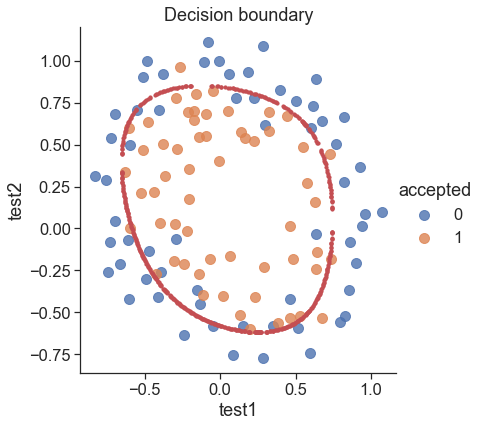

In [187]:
draw_boundary(power=6, l=1)     # lambda=1

d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


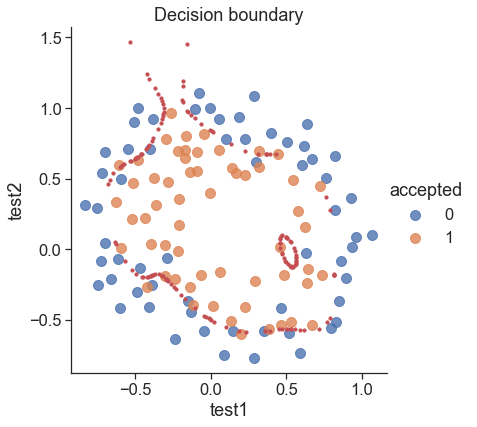

In [188]:
draw_boundary(power=6, l=0)     # no regularization, over fitting，#lambda=0,没有正则化，过拟合了

d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\pyprojectin\pytorch\venv\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


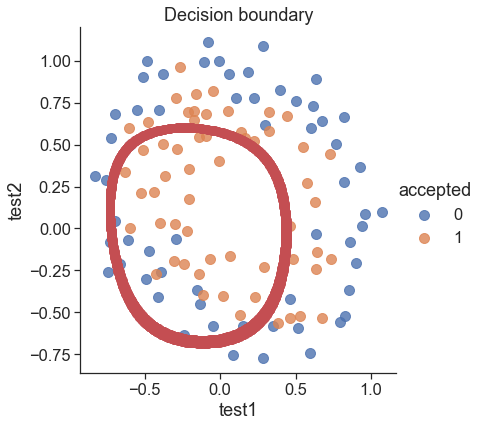

In [189]:
draw_boundary(power=6, l=100)   # underfitting，#lambda=100,欠拟合
